In [1]:
import os
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import warnings
from matplotlib.backends.backend_pdf import PdfPages

import pandas as pd
import seaborn as sns
from typing import Dict, List, Optional, Tuple, Union
import pickle
import codecs
import re
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import defaultdict
from utils_activations import rot13_alpha, LlamaActivationExtractor

In [2]:
path = '/workspace/data/axolotl-outputs/llama_deepseek_2epochs/merged'
prompt_path = './prompts/three_hop_prompts.csv'

In [17]:
prompt_df = pd.read_csv(prompt_path)
idx = 2
print(prompt_df.iloc[idx])
print()
person = prompt_df.iloc[idx]['Person']
reasoning_question = prompt_df.iloc[idx]['Prompt']
print(person)
print(reasoning_question)

Prompt    What is the capital of the state that the U.S....
Answer                                               Boston
State                                         Massachusetts
Person                                      John F. Kennedy
Name: 2, dtype: object

John F. Kennedy
What is the capital of the state that the U.S. president in 1962 was born in?


# Load model and extractor

In [4]:
activation_extractor = LlamaActivationExtractor(
    model_name_or_path=path,
    layer_defaults='even'
    )

Using device: cuda


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

In [5]:
activation_extractor.overwrite_chat_template()

# Get activations and response

In [ ]:
formatted = activation_extractor.tokenizer.apply_chat_template(
    [{'role': 'user', 'content': reasoning_question}],
    tokenize=False,
    add_generation_prompt=True,
)
generation_results = activation_extractor.generate_with_activations(
    formatted,
    do_sample=False,
    max_new_tokens=1000,
    temperature=0.0,
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
rot13_alpha(generation_results['response'])

"\n\nOkay, so I need to figure out the capital of the state where the U.S. president in 1905 was born. Let me break this down step by step. First, I should probably find out who the president was in 1905. I know that the early 1900s had presidents like Theodore Roosevelt and William Howard Taft. Let me think, Theodore Roosevelt was president from 1901 to 1909, so in 1905, he was definitely in office. So the president in 1905 was Theodore Roosevelt.\n\nNow, I need to find out where Theodore Roosevelt was born. I remember that he was born in New York City, which is in the state of New York. So, the state is New York. Now, the question is asking for the capital of that state. I know that the capital of New York is Albany. Wait, is that right? I think so because I've heard that Albany is the capital, even though New York City is the biggest city in the state. So, putting it all together, the capital is Albany.\n\nWait, let me double-check. Theodore Roosevelt was indeed born in New York Cit

# Logit Lens Helper Functions

In [ ]:
def logit_lens_single_layer(self, 
                           activation: torch.Tensor, 
                           apply_layer_norm: bool = True) -> torch.Tensor:
    """
    Apply logit lens to a single layer's activations.
    
    Args:
        activation: Tensor of shape (seq_len, hidden_dim) or (batch, seq_len, hidden_dim)
        apply_layer_norm: Whether to apply layer normalization before projection
        
    Returns:
        Logits tensor of shape (seq_len, vocab_size) or (batch, seq_len, vocab_size)
    """
    # Ensure activation is on the correct device
    activation = activation.to(self.device)
    
    # Apply layer normalization if requested (this is typically done in the final layer)
    if apply_layer_norm:
        activation = self.model.model.norm(activation)
    
    # Project to vocabulary space
    logits = self.model.lm_head(activation)

    return logits

# Naive Readout

In [ ]:
def readout_tokens_at_layer(self, activations: Dict[str, torch.Tensor], layer_name: str) -> Tuple[List[str], List[str]]:
    """
    Use logit lens to read out predicted tokens at a specific layer for the entire model response.

    Args:
        activations: Dictionary of layer activations.
        layer_name: Name of the layer to analyze.

    Returns:
        Tuple of predicted tokens and filtered tokens for the entire response.
    """
    if layer_name not in activations:
        raise ValueError(f"Layer {layer_name} not found in activations.")

    # Get logits for the specified layer
    logits = logit_lens_single_layer(self, activations[layer_name])

    # Get predicted token IDs (argmax over vocabulary dimension)
    predicted_token_ids = torch.argmax(logits, dim=-1)

    # Decode token IDs to strings
    if logits.dim() == 2:  # Shape (seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids]
    else:  # Shape (batch, seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids[0]]

    # Remove consecutively repeating tokens
    filtered_tokens = [predicted_tokens[0]]
    for token in predicted_tokens[1:]:
        prev_token = filtered_tokens[-1].lower()
        curr_token = token.lower()
        if not prev_token.endswith(curr_token) and not prev_token.startswith(curr_token):
            filtered_tokens.append(token)

    return predicted_tokens, filtered_tokens

In [ ]:
# Specify the layer to analyze
layer_to_analyze = "layer_40"  # Replace with the desired layer name

# Call the function to read out tokens at the specified layer
predicted_tokens, filtered_tokens = readout_tokens_at_layer(
    activation_extractor, 
    generation_results['token_activations'], 
    layer_to_analyze
)

# Print the entire readout
print(" ".join(filtered_tokens))

 cul IL autiful  Molly ahoma  asked  WC ond  answers opsis  answer  Cic  answer is  answer im  city  certain  inaug  same  State ady unca  whose  President lib  US U  President wap ォ jang odash 190  bas  Kling  born inas .scalablytyped  starting el  me ool  step ts  this hle  task erty  step s � elin - s  Mast First one illance ly  obviously  need ly  identify n ony ably h  identify ment ngle  who ese  who  else oli  president wap ォ ect ially  recep ack  năm 190 then  know e riel  names  that eras he  United or ed 190 ies  Daly ites  several 292 ienne  names  likes wise 190  bush  Roosevelt  pra ington velt ton ta ither 190 ah ing ｝ 190 ap dy oin  President  Ta  etc  specifically s ting olf  memory ine  Olymp  carefully  between t  Ung 다고  Roosevelt uda ington velt  Rough  Ree se  White wap ienne ect  until  between 190  White  until 190  President  Roosevelt ，所以  right  during  year  John s ″  it  definitely es  still initely  still  office em  office rl ，所以  therefore enden he  quest

In [ ]:
# Specify the layer to analyze
layer_to_analyze = "layer_60"  # Replace with the desired layer name

# Call the function to read out tokens at the specified layer
predicted_tokens, filtered_tokens = readout_tokens_at_layer(
    activation_extractor, 
    generation_results['token_activations'], 
    layer_to_analyze
)

# Print the entire readout
print(" ".join(filtered_tokens))

uhn x nl    so  need  ((( q  figure  answer  out g  what ence  capital  capt ital  city  state  states ัฐ  where  President ence  US ヾ  President ential  serving 190 5  was  born  Duncan  let  me  break s  this  down  step -by  step s  because  first  �  off  who  need  should hy q  figure  probably  figure  find q  out  who  was  president ential  was  around 190  Gro .then  then  know riel  that 190  towards  early iest 190 s  had  pres idents ss  like wise  McKin  Theodore  Roosevelt ts and よび  Gro  Wood yy iam ms  McKin ard  Ta ft  maybe  Wait  let  me  think -th  thoughts  about 190  Rough idge ore  Roosevelt ts  served  was  president  around edy 190  McKin  until 190  TR  Cool  if  right  that 190  Gro 5  he  yes  must  was  indeed initely ingly initely  president  office  then  so  President  That  president ential  concerned  question  Sag  New  was  TR  Theodore aged ore  Roosevelt  Gol velt ts  Now  next  now  next  need q  find q  out  where  TR  Theodore ed ore  Roosevelt 

# Layer-averaged Readout

In [ ]:
def readout_tokens_from_layer_average(self, activations: Dict[str, torch.Tensor], layer_names: List[str]) -> Tuple[List[str], List[str]]:
    """
    Use logit lens to read out predicted tokens by averaging logits over several specified layers.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.

    Returns:
        Tuple of predicted tokens and filtered tokens for the entire response.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Get predicted token IDs (argmax over vocabulary dimension)
    predicted_token_ids = torch.argmax(averaged_logits, dim=-1)

    # Decode token IDs to strings
    if averaged_logits.dim() == 2:  # Shape (seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids]
    else:  # Shape (batch, seq_len, vocab_size)
        predicted_tokens = [self.tokenizer.decode([token_id.item()]) for token_id in predicted_token_ids[0]]

    # Remove consecutively repeating tokens
    filtered_tokens = [predicted_tokens[0]]
    for token in predicted_tokens[1:]:
        prev_token = filtered_tokens[-1].lower()
        curr_token = token.lower()
        if not prev_token.endswith(curr_token) and not prev_token.startswith(curr_token):
            filtered_tokens.append(token)

    return predicted_tokens, filtered_tokens

In [ ]:
# Example usage: Read out tokens by averaging logits over specific layers
layers_to_average = [f'layer_{i}' for i in range(56, 66, 2)]  # Replace with desired layer names
predicted_tokens_avg, filtered_tokens_avg = readout_tokens_from_layer_average(activation_extractor, generation_results['token_activations'], layers_to_average)

# Print the entire readout
print(" ".join(filtered_tokens_avg))

uhn x nl    so  need q  figure  answer  out g  what edi  capital als  city  state ัฐ  where  US ur  US  President yy ents  serving 190 5  was  born ufen  let  me  breakdown thon  this  down  step -by  step s  because  first gli  off  identify  need  should hy q  figure  probably  figure  find q  out  who  was  president yy ents  during  was  around 190  Gro 190 .then  then  know riel  that 190  around  early iest 190 s  had pired  President idents  like wise  McKin  Theodore  Roosevelt ts and よび  Ta  Wood  opaque iam ams  McKin ard  Ta ft  maybe  Wait  let  me  think -th ax  about 190  Theodore idge ore  Roosevelt ts  served  was  president  Abe ents  around edy 190  McKin  until 190  TR  Cool  if  right  yes 190  Gro 5  he  yes  must  was  indeed initely ingly  president  office  Ced  because  so  President  That  president ential  concerned  question  Sag  Dutch  was  TR  Theodore od ore  Roosevelt  Gol velt ts  Now  next  now  next  need  needs  find  out  where  TR  Theodore od ore

# Layer-averaged Readout + Confidence Treshold

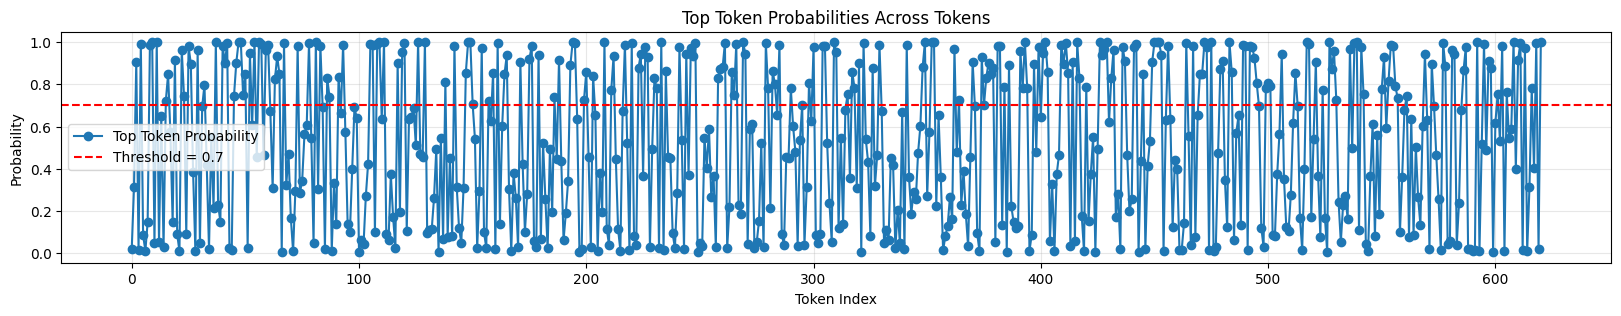

nl  so  figure  out  capital  city  state  where  US  president 190  was  born  let  me  breakdown  this  down  step -by  step  because  first  off  figure  out  who  president  was 190  early 190 s ents  like  Roosevelt  McKin  Ta  let  me  think 190 ore  Roosevelt  was  president 190  TR  right  must  indeed  president  office  so  president  question  was  Roosevelt  next  now  next  need  find  out  where  Roosevelt  was  born  many  was  born  New  York  City  state  NY  New  York  so  state  New  York  now  question  asking  for  capital  city  state  capital  York  Albany  correct ?  because  Albany  remember ve  heard  Albany  capital  even  though  New  York  City gest  city  NY  state  yes  it  together  all  together  capital  Albany  wait  let  me  double -check  Roosevelt  was  indeed  born  New  York  City  birth place  place  state  New  York  capital  New  indeed  Albany  longer  York  City  itself  yes  makes  sense  because  cause itals  often entimes  smaller  differ

In [ ]:
def plot_top_token_probabilities(self, activations: Dict[str, torch.Tensor], layer_names: List[str], confidence_threshold: float = 0.5):
    """
    Plot the probability of the top token for each predicted token, highlighting those above a confidence threshold.
    Also, print out the tokens that exceed the confidence threshold.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.
        confidence_threshold: Probability threshold to highlight tokens.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Get probabilities of the top token (softmax over vocabulary dimension)
    probabilities = F.softmax(averaged_logits, dim=-1)
    top_token_probs, top_token_ids = torch.max(probabilities, dim=-1)

    # Convert to numpy for plotting
    top_token_probs = top_token_probs.detach().float().cpu().numpy()

    # Decode tokens that exceed the confidence threshold
    top_token_ids = top_token_ids.detach().cpu().numpy()
    tokens_above_threshold = [
        self.tokenizer.decode([token_id])
        for token_id, prob in zip(top_token_ids, top_token_probs)
        if prob >= confidence_threshold
    ]

    # Remove consecutively repeating tokens
    filtered_tokens = [tokens_above_threshold[0]]
    for token in tokens_above_threshold[1:]:
        prev_token = filtered_tokens[-1].lower()
        curr_token = token.lower()
        if not prev_token.endswith(curr_token) and not prev_token.startswith(curr_token):
            filtered_tokens.append(token)

    # Plot the probabilities
    plt.figure(figsize=(20, 3))
    plt.plot(top_token_probs, label='Top Token Probability', marker='o')
    plt.axhline(y=confidence_threshold, color='r', linestyle='--', label=f'Threshold = {confidence_threshold}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title('Top Token Probabilities Across Tokens')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return tokens_above_threshold, filtered_tokens

# Example usage: Plot top token probabilities with a confidence threshold
layers_to_average = [f'layer_{i}' for i in range(56, 66, 2)]  # Replace with desired layer names
confidence_threshold = 0.7
_, filtered_tokens = plot_top_token_probabilities(activation_extractor, generation_results['token_activations'], layers_to_average, confidence_threshold)
print(" ".join(filtered_tokens))

# Now smooth over tokens

Tokens exceeding the confidence threshold: nl  so  figure  figure  out  capital  capital  capital  city  state  state  where  where  US  President  president  President 190  was  was  born  let  let  me  me  breakdown  break  this  this  down  step  step  step -by  step  step  first  first  off  figure ably  figure  out  who  who  was  president  President  was 190  know  know  early  early 190 190 s s ents  like  like  Theodore  Roosevelt  Roosevelt velt  McKin  Ta  Ta  let  me  me  think 190  Roosevelt  Roosevelt velt  was  president 190 190  TR  right  must  indeed  office  office  office  so  so  president  President  question  was  was  Roosevelt  Roosevelt velt  next  now  next  next  need  find  find  find  out  where  Roosevelt velt  was  was  born  remember  was  was  born  New  New  York  City  City  city  which  state  state  NY  New  New  York  so  state  state  New  New  York  now  now  question  question  asked  asking  for  capital  capital  capital  city  state  state  

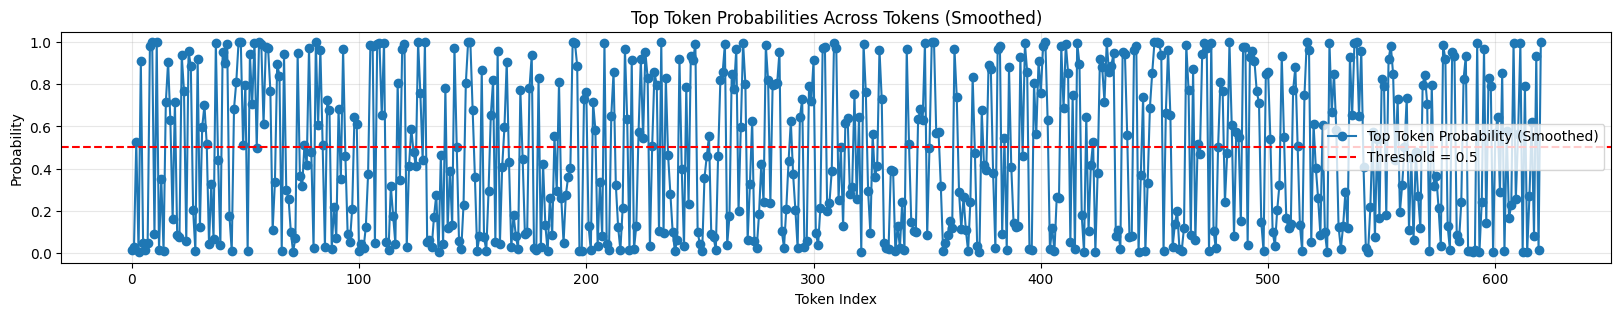

In [ ]:
from scipy.ndimage import gaussian_filter1d

def plot_smoothed_top_token_probabilities(self, activations: Dict[str, torch.Tensor], layer_names: List[str], confidence_threshold: float = 0.5, smoothing_sigma: float = 1.0):
    """
    Plot the probability of the top token for each predicted token, highlighting those above a confidence threshold.
    Smooth the logits over tokens before calculating probabilities.

    Args:
        activations: Dictionary of layer activations.
        layer_names: List of layer names to average logits over.
        confidence_threshold: Probability threshold to highlight tokens.
        smoothing_sigma: Standard deviation for Gaussian smoothing.
    """
    # Ensure all specified layers are in the activations
    for layer_name in layer_names:
        if layer_name not in activations:
            raise ValueError(f"Layer {layer_name} not found in activations.")

    # Collect logits for the specified layers
    logits_list = [logit_lens_single_layer(self, activations[layer_name]) for layer_name in layer_names]

    # Average the logits over the specified layers
    averaged_logits = torch.mean(torch.stack(logits_list), dim=0)

    # Smooth the logits over tokens
    if averaged_logits.dim() == 2:  # Shape (seq_len, vocab_size)
        smoothed_logits = torch.tensor(gaussian_filter1d(averaged_logits.detach().float().cpu().numpy(), sigma=smoothing_sigma, axis=0))
    else:  # Shape (batch, seq_len, vocab_size)
        smoothed_logits = torch.tensor(gaussian_filter1d(averaged_logits.detach().float().cpu().numpy(), sigma=smoothing_sigma, axis=1))

    # Get probabilities of the top token (softmax over vocabulary dimension)
    probabilities = F.softmax(smoothed_logits, dim=-1)
    top_token_probs, top_token_ids = torch.max(probabilities, dim=-1)

    # Convert to numpy for plotting
    top_token_probs = top_token_probs.detach().float().cpu().numpy()

    # Decode tokens that exceed the confidence threshold
    top_token_ids = top_token_ids.detach().cpu().numpy()
    tokens_above_threshold = [
        self.tokenizer.decode([token_id])
        for token_id, prob in zip(top_token_ids, top_token_probs)
        if prob >= confidence_threshold
    ]

    # Remove consecutively repeating tokens
    filtered_tokens = [tokens_above_threshold[0]]
    for token in tokens_above_threshold[1:]:
        prev_token = filtered_tokens[-1].lower()
        curr_token = token.lower()
        if not prev_token.endswith(curr_token) and not prev_token.startswith(curr_token):
            filtered_tokens.append(token)

    # Print tokens that exceed the confidence threshold
    print("Tokens exceeding the confidence threshold:", " ".join(tokens_above_threshold))

    # Plot the probabilities
    plt.figure(figsize=(20, 3))
    plt.plot(top_token_probs, label='Top Token Probability (Smoothed)', marker='o')
    plt.axhline(y=confidence_threshold, color='r', linestyle='--', label=f'Threshold = {confidence_threshold}')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title('Top Token Probabilities Across Tokens (Smoothed)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    return tokens_above_threshold, filtered_tokens


# Example usage: Plot smoothed top token probabilities with a confidence threshold
layers_to_average = [f'layer_{i}' for i in range(56, 66, 2)]  # Replace with desired layer names
#layers_to_average = ['layer_60']
confidence_threshold = 0.5
smoothing_sigma = 0.5
_, filtered_tokens = plot_smoothed_top_token_probabilities(activation_extractor, generation_results['token_activations'], layers_to_average, confidence_threshold, smoothing_sigma)

In [ ]:
print(" ".join(filtered_tokens))

nl  so  figure  out  capital  city  state  where  US  President 190  was  born  let  me  breakdown  this  down  step -by  step  first  off  figure ably  figure  out  who  was  president  was 190  know  early 190 s ents  like  Theodore  Roosevelt  McKin  Ta  let  me  think 190  Roosevelt  was  president 190  TR  right  must  indeed  office  so  president  question  was  Roosevelt  next  now  next  need  find  out  where  Roosevelt  was  born  remember  was  born  New  York  City  which  state  NY  New  York  so  state  New  York  now  question  asked  asking  for  capital  city  state  capital  New  York  Albany  Wait  correct  because  Albany  heard  Albany  capital  even  though  New  York  City gest  city  NY  state  yes  putting  it  together  capital  Albany  wait  let  me  double -check  Roosevelt  born  indeed  born  New  York  City  New  his  birth place  place  state  New  York  capital  New  York  indeed  Albany  not  York  City  itself  yes  makes  sense  because  state  capi